## Buoyancy Frequency and Drag Figures

For this script to run you need to download 'revised_stat'. This script is written by Madie Mamer (mmamer3@gatech.edu).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
import matplotlib.colors
import cmocean as cmo
import seaborn as sns
from matplotlib.colors import ListedColormap

In [10]:
nu = 1.95 * 10 **(-6)
sec_to_year = 3600 * 24 * 365
path = 'averagedRuns'

## F1, varying Turbulence ##
F1cu1_body = pd.read_csv(path + '/f1cu1_ys_body.csv')
F1cu2_body = pd.read_csv(path + '/f1cu2_ys_body.csv')
F1cu3_body = pd.read_csv(path + '/f1cu3_ys_body.csv')
F1cu2_m_body = pd.read_csv(path + '/f1cu2_m_ys_body.csv')

## F2, varying Turbulence ##
F2cu1_body = pd.read_csv(path + '/f2cu1_ys_body.csv')
F2cu3_body = pd.read_csv(path + '/f2cu2_ys_body.csv')
F2cu2_body = pd.read_csv(path + '/f2cu3_ys_body.csv')
F2cu2_m_body = pd.read_csv(path + '/f2cu2_m_ys_body.csv')

## F3, varying Turbulence ##
#F3cu1_body = pd.read_csv(path + '/f3cu1_ys_body.csv')
F3cu2_body = pd.read_csv(path + '/f3cu2_ys_body.csv')
F3cu3_body = pd.read_csv(path + '/f3cu3_ys_body.csv')

F4cu2_body = pd.read_csv(path + '/f4cu2_theta1_body.csv')

F5cu2_body = pd.read_csv(path + '/f5cu2_ys_body.csv')


## drag Function

For this function you need to pass a time-averaged domain body file (df) and set True or False for if the domain is slanted. You also need to give it the freshwater discharge velocity in m/s (u_f).
This function calculates the near wall velocity gradientand returns it as an array.

In [5]:
def linear(x, a, b):
    return a * x**1 + b

def quadratic(x, a, b, c):
    return a * x**2 + b * x**1 + c

def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x**1 + d

def quartic(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d*x + e

def exponential(x, a, b, c, d, e):
    return a * np.exp(b * x) + c

## Derivative Functions ##
def quartic_deriv(x, a, b, c, d):
    return 4 * a * x**3 + 3 * b * x**2 + 2 * c * x + d

In [6]:
def drag_sloped(body_data, u_f):
    nu = 1.95 * 10 **(-6)
    a = body_data
    b = a.iloc[np.where(a.x > 2)[0],:]
    c = b
    c = c.sort_values('y')
    c.x = c.x.round(2)
    gb = c.groupby('x')

    xs = gb.groups.keys()
    df = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd'])
    i = 0
    #xs = np.linspace(2.01, 2.05, 5).round(2)

    #cT = cmo.cm.matter_r(np.linspace(0,1,len(xs)+1))
    #fig, ax = plt.subplots(2, figsize = (10,5), dpi = 300)
    #rmse_all = np.zeros(len(xs))

    for x in xs:
        #rmse = np.zeros(5)
        #ax[0].scatter(gb.get_group(x).avg_xVel, gb.get_group(x).y, color = cT[i])

        ydata = gb.get_group(x).y
        ydata = ydata - np.max(ydata) + 0.05
        xVel_data = gb.get_group(x).avg_xVel
    
        new_y = np.linspace(np.max(ydata)/2, ydata.iloc[-1], 50)
        new_xVel = griddata((np.array(ydata)), np.array(xVel_data), (new_y))

        dudy = np.gradient(new_xVel[:], new_y[:])
        #ax[1].plot(dudy, new_y - 0.05, marker = 'o', color = cT[i])
        #ax[1].plot(np.zeros(len(new_y)), new_y - 0.05, color = 'k')
        cond = np.where(dudy > 0)[0]

        if len(cond) < 2:
            df.iloc[i,0] = 0
        else:
            params_dudy, pcov = curve_fit(linear, new_y[cond], new_xVel[cond], maxfev = 1000)
            #ax[3].plot(new_xVel[cond], new_y[cond] - 0.05, marker = 'o',linewidth = 0.5, color = cT[i])
            #ax[1].scatter(dudy[cond], new_y[cond])
            #ax[3].plot(linear(new_y[cond], *params_dudy), new_y[cond] - 0.05, linewidth = 2, color = cT[i], zorder = 2)
            df.iloc[i,0] = params_dudy[0]
            df.iloc[i,1] = params_dudy[1]
            df.iloc[i,2] = 2 * nu * params_dudy[0]  / np.nanmax(abs(u_f))**2

        i = i + 1
    return df


In [13]:
drag_f4cu2 = drag_sloped(F4cu2_body, 0.005)


In [ ]:
def drag(body_data, u_f, sloped):
    
    nu = 1.95 * 10 **(-6)
    a = body_data
    b = a.iloc[np.where(a.x > 2)[0],:]
    c = b.iloc[np.where(b.y > 0.025)[0],:]
    c = c.sort_values('y')
    c.x = c.x.round(2)
    gb = c.groupby('x')

    xs = list(gb.groups.keys())
    df = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd', 'mean_xVel'])
    i = 0
    #xs = np.linspace(2.01, 2.05, 5).round(2)

    cT = cmo.cm.matter_r(np.linspace(0,1,len(xs)+1))
    # fig, ax = plt.subplots(1,4, figsize = (18,6), dpi = 300)
    rmse_all = np.zeros(len(xs))

    for x in xs:
        #rmse = np.zeros(5)
        # ax[0].scatter(gb.get_group(x).avg_xVel, gb.get_group(x).y - 0.05, s = 7, color = cT[i], label = x)

        ydata = gb.get_group(x).y
        xVel_data = gb.get_group(x).avg_xVel
        
        new_y = np.linspace(np.max(ydata)/2, ydata.iloc[-1], 50)
        new_xVel = griddata((np.array(ydata)), np.array(xVel_data), (new_y))

        # params_l, pcov = curve_fit(linear, ydata, xVel_data, maxfev = 5000)
        # params_quad, pcov = curve_fit(quadratic, ydata, xVel_data, maxfev = 5000)
        # params_c, pcov = curve_fit(cubic, ydata, xVel_data, maxfev = 5000)
        # params_quar, pcov = curve_fit(quartic, ydata, xVel_data, maxfev = 5000)
        # params_e, pcov = curve_fit(exponential, ydata, xVel_data, maxfev = 5000)

        # ax[0].plot(linear(ydata, *params_l), ydata,color = 'red', label = 'Linear Fit')
        # ax[0].plot(quadratic(ydata, *params_quad), ydata, color = 'blue', label = 'Quadratic Fit')
        # ax[0].plot(cubic(ydata, *params_c), ydata, color = 'green', label = 'Cubic Fit')
        # ax[0].plot(quartic(ydata, *params_quar), ydata, color = 'orange', label = 'Quartic Fit')
        # ax[0].plot(exponential(ydata, *params_e), ydata, color = 'pink', label = 'Exp. Fit')

        dudy = np.gradient(new_xVel[:], new_y[:])
        # ax[1].plot(dudy, new_y - 0.05, marker = 'o',markersize = 3, linewidth = 0.75, color = cT[i])
        # ax[1].plot(np.zeros(len(new_y)), new_y - 0.05, color = 'k')
        cond = np.where(dudy > 0)[0]
        # ax[2].plot(new_xVel[cond], new_y[cond] - 0.05, marker = 'o', linewidth = 0.75, markersize = 3, color = cT[i])

        if len(cond) < 2:
            df.iloc[i,0] = 0
        else:
            params_dudy, pcov = curve_fit(linear, new_y[cond], new_xVel[cond], maxfev = 1000)
            # ax[3].plot(new_xVel[cond], new_y[cond] - 0.05, marker = 'o',linewidth = 0.75, markersize = 3, color = cT[i], zorder = 1)
            #ax[1].scatter(dudy[cond], new_y[cond])
            # ax[3].plot(linear(new_y[cond], *params_dudy), new_y[cond] - 0.05, linewidth = 2, color = cT[i], zorder = 2)
            df.iloc[i,0] = params_dudy[0]
            df.iloc[i,1] = params_dudy[1]
            df.iloc[i,2] = 2 * nu * params_dudy[0]  / np.nanmax(abs(u_f))**2
        # rmse[0] = np.sqrt(np.mean((xVel_data - linear(ydata, *params_l)) ** 2))
        # rmse[1] = np.sqrt(np.mean((xVel_data - quadratic(ydata, *params_quad)) ** 2))
        # rmse[2] = np.sqrt(np.mean((xVel_data - cubic(ydata, *params_c)) ** 2))
        # rmse[3] = np.sqrt(np.mean((xVel_data - quartic(ydata, *params_quar)) ** 2))
        # rmse[4] = np.sqrt(np.mean((xVel_data - exponential(ydata, *params_e)) ** 2))

        # idx = np.argmin(rmse)

        # if idx == 0:
        #     #print('linear')
        #     rmse_all[i] = 0#rmse[0]
        # elif idx == 1:
        #     #print('quadratic')
        #     rmse_all[i] = 1#rmse[1]
        # elif idx == 2:
        #     #print('cubic')
        #     rmse_all[i] = 2#rmse[2]
        # elif idx == 3:
        #     #print('quartic')
        #     rmse_all[i] = 3#rmse[3]
        # else:
        #     #print('exponential')
        #     rmse_all[i] = 4#rmse[4]

        #ax[1].plot(quartic_deriv(ydata, a, b, c, d), ydata, color = cT[i])

        #df.iloc[i,0] = np.mean(abs(cubic_deriv(xdata, a, b, c,d)))
        #df.iloc[i,1] = popt[1]
    
        i = i + 1

    # ax[0].set_xlabel('u m/s')
    # ax[0].set_ylabel('y [m]')
    # ax[1].set_xlabel('du/dy s$^{-1}$')
    # ax[2].set_xlabel('u m/s')
    # ax[3].set_xlabel('u m/s')
    # ax[0].legend(loc = 3); ax[0].set_ylim(-0.025,0);
    # ax[1].set_ylim(-0.025,0);
    # ax[2].set_ylim(-0.008,0);
    # ax[3].set_ylim(-0.008,0);

    # ax[0].set_title('x-Velocity Profiles')
    # ax[1].set_title('x-Velocity Gradient')
    # ax[2].set_title('x-Velocity where Gradient > 0')
    # ax[3].set_title('Linear Fit of x-Velocity')



    # plt.tight_layout()
    # plt.savefig('dudy_linearFit.png', dpi = 500)
    #plt.hist(rmse_all, bins = [0,1,2,3,4])
    return df

,slope,intercept,Cd,mean_xVel
2.00,18.401838,-0.961328,2.870687,NaN
2.01,12.98843,-0.666179,2.026195,NaN
2.02,7.89532,-0.409647,1.23167,NaN
2.03,5.646535,-0.296303,0.880859,NaN
2.04,5.648524,-0.293011,0.88117,NaN


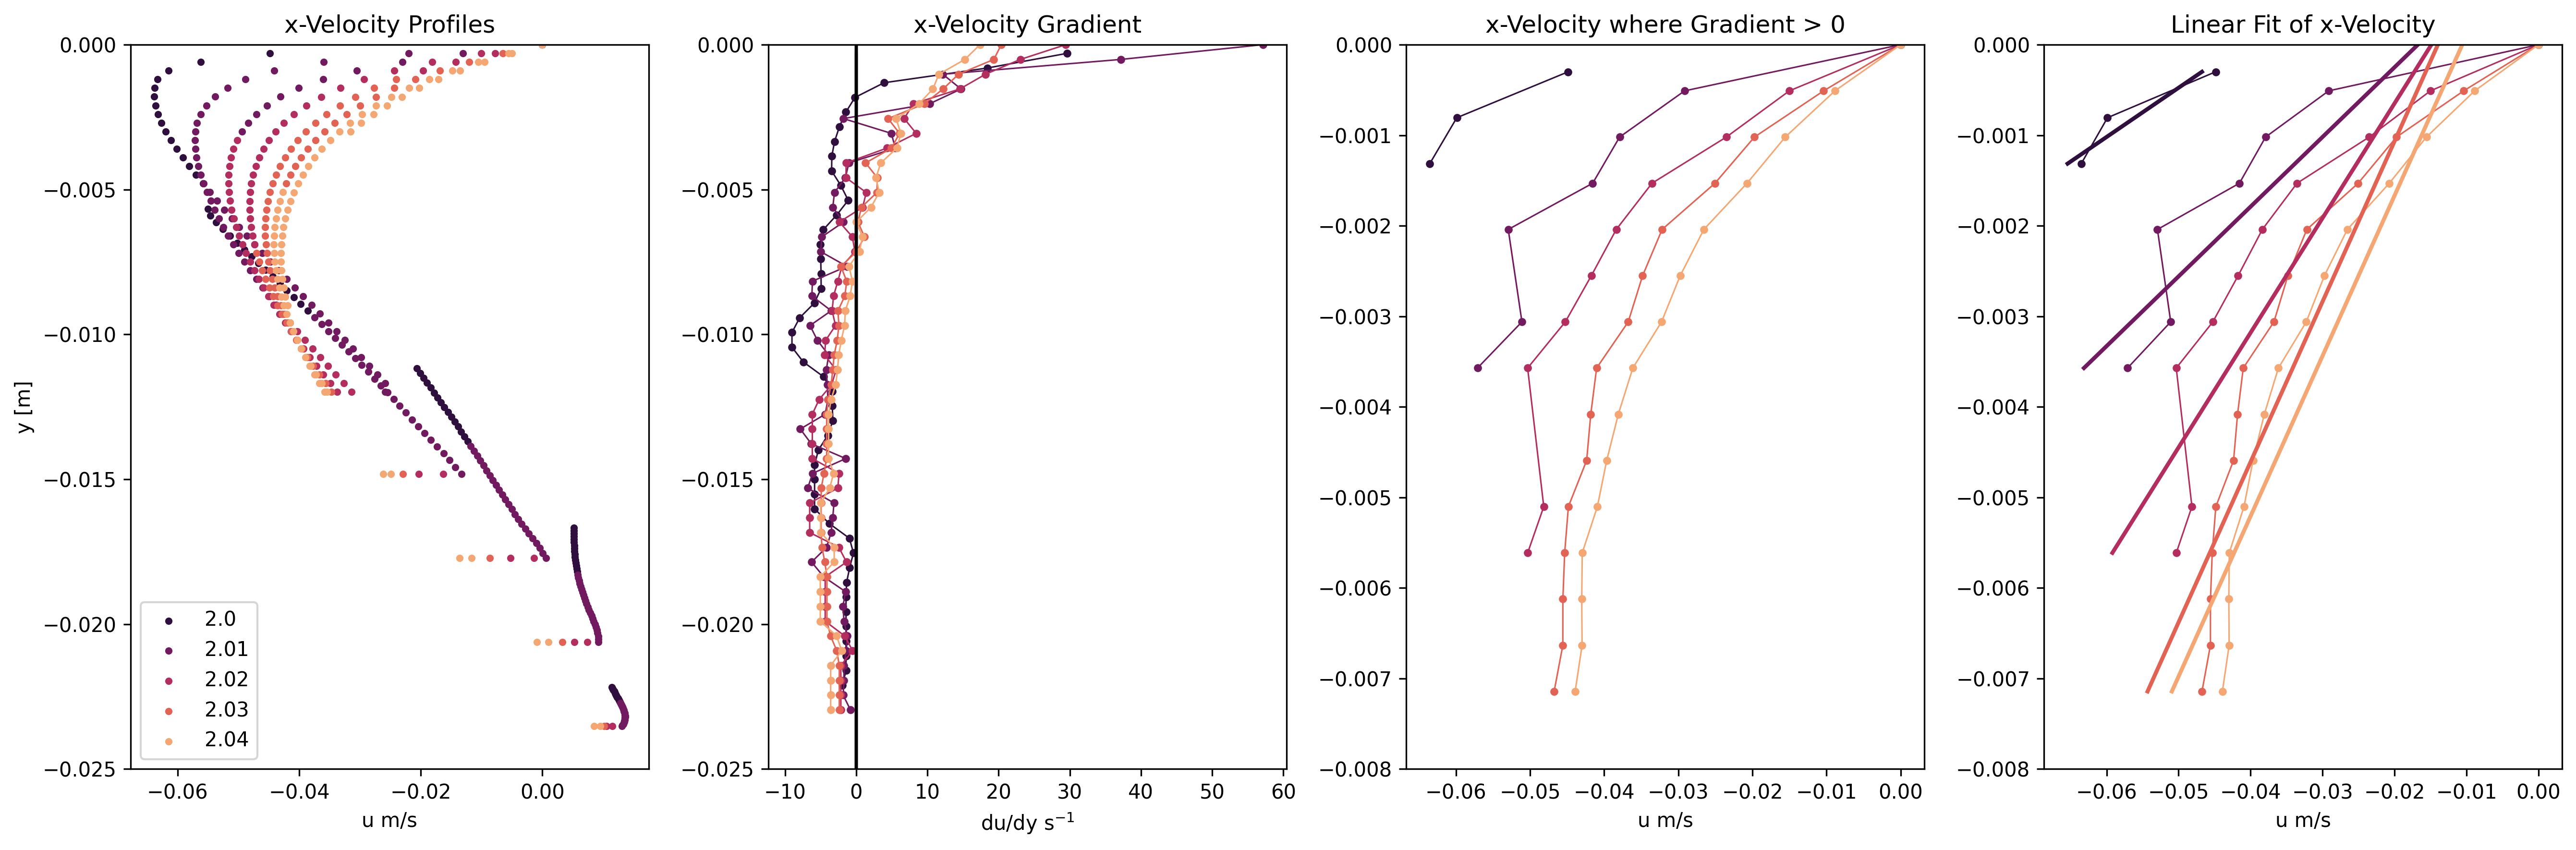

In [123]:
drag(F2cu2_body, 0.005, False)

In [39]:
## F1, varying turbulence
drag_f1cu1 = drag(F1cu1_body, 0.05, False)
drag_f1cu2 = drag(F1cu2_body, 0.05, False)
drag_f1cu3 = drag(F1cu3_body, 0.05, False)
drag_f1cu2_m = drag(F1cu2_m_body, 0.05, False)

## F2, varying turbulence
drag_f2cu1 = drag(F2cu1_body, 0.005, False)
drag_f2cu2 = drag(F2cu2_body, 0.005, False)
drag_f2cu3 = drag(F2cu3_body, 0.005, False)
drag_f2cu2_m = drag(F2cu2_m_body, 0.005, False)
## F3, varying turbulence
# drag_f3cu1 = drag(F3cu1_body, 0.0005)
drag_f3cu2 = drag(F3cu2_body, 0.0005, False)
drag_f3cu3 = drag(F3cu3_body, 0.0005, False)

## F4
# drag_f4cu2 = drag(F4cu2_body, 0.005, True)

## F5
drag_f5cu2 = drag(F5cu2_body, 0.005, False)



/Users/mmamer3/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/mmamer3/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/mmamer3/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/mmamer3/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/mmamer3/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py

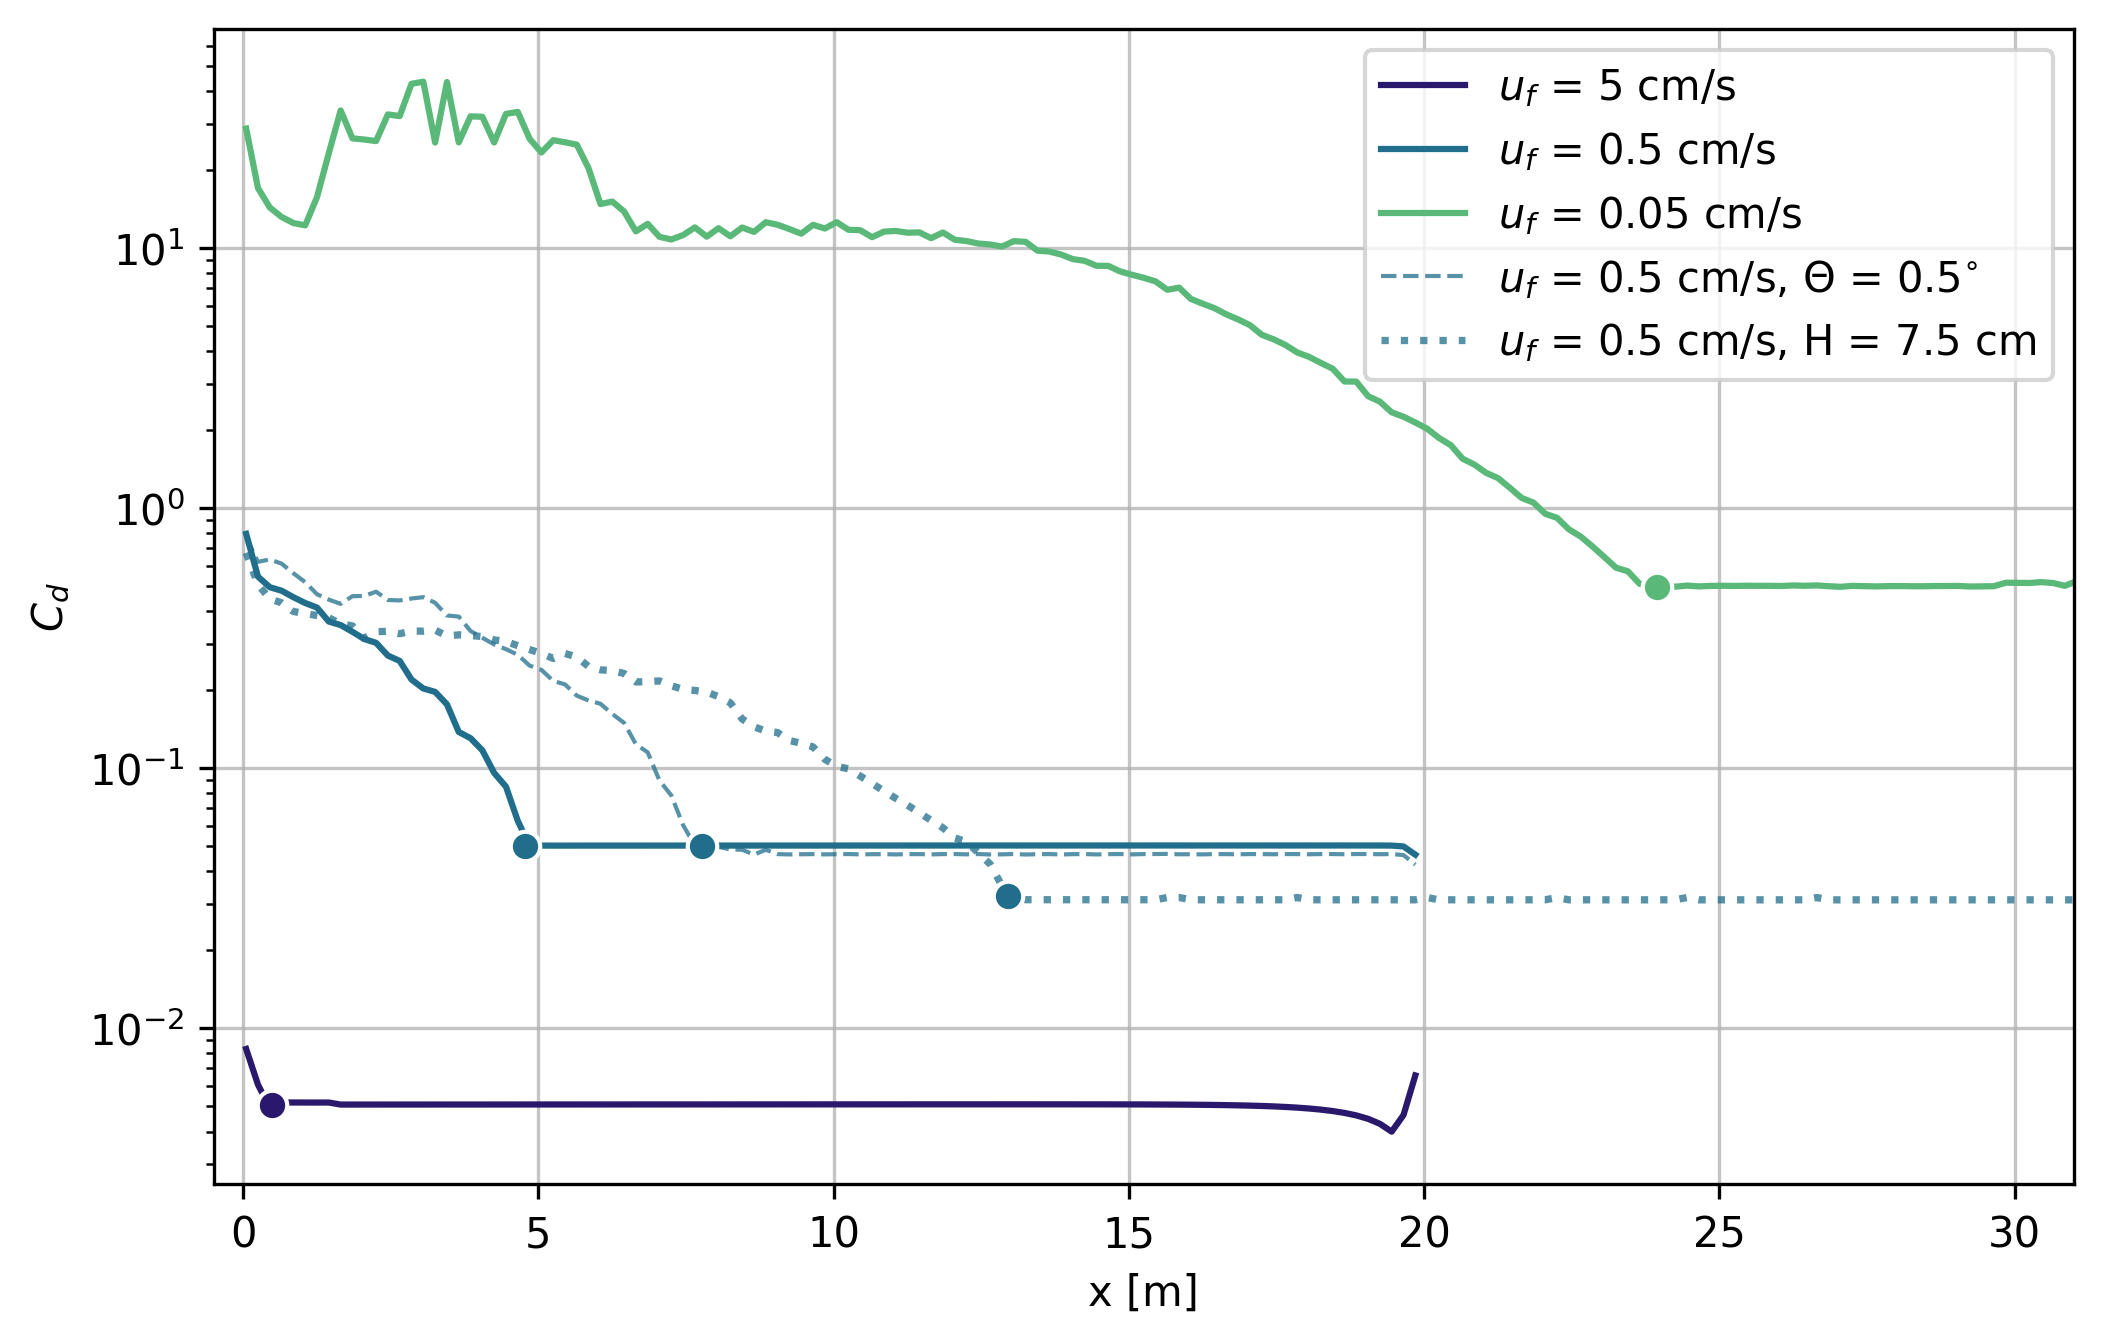

In [46]:
f2cu2_intru = 4.78
f1cu2_intru = 0.49
f3cu2_intru = 23.95
f4cu2_theta1_intru = 7.77
f5cu2_intru = 12.95

intrus = [f1cu2_intru, f2cu2_intru, f3cu2_intru, f4cu2_theta1_intru, f5cu2_intru]
data = [drag_f1cu2, drag_f2cu2, drag_f3cu2, drag_f4cu2, drag_f5cu2]
labels = ['$u_f$ = 5 cm/s',
          '$u_f$ = 0.5 cm/s',
          '$u_f$ = 0.05 cm/s',
          '$u_f$ = 0.5 cm/s, $\Theta$ = 0.5$^{\circ}$',
          '$u_f$ = 0.5 cm/s, H = 7.5 cm']
n = 3 #en(data)
cT = cmo.cm.haline(np.linspace(0,1,n+1))
colors = [cT[0], cT[1], cT[2], cT[1], cT[1]]

fig, ax = plt.subplots(1, figsize = (8,5), dpi = 300)
i = 0
for each in data:
    if i == 3:
        line = '--'
        a = 0.75
        width = 1
    elif i == 4:
        line = ':'
        a = 0.75
        width = 1.75
    else:
        line = '-'
        a = 1
        width = 1.5
    intru = np.argmin(abs(np.array(each.index - 2) - intrus[i]))
    f1, = ax.plot(each.index[5:-5:20] - 2, each.Cd.iloc[5:-5:20], linewidth = width, color = colors[i], linestyle = line, alpha = a, label = labels[i])
    ax.scatter(each.index[intru] - 2, each.Cd.iloc[intru], color = colors[i],
            s = 50,edgecolor='white',linewidth = 1, zorder = 2)
    i = i + 1
ax.set_xlabel('x [m]'); ax.set_ylabel('$C_d$');
ax.set_xlim(-0.5,31); ax.grid(alpha = 0.75)
#ax.legend([f1, f2], ['$u_f = 5 cm/s$', '$u_f = 0.5 cm/s$'])
ax.set_yscale('log')
ax.legend(loc = 1)#, bbox_to_anchor = [0.505,-0.275], ncols = 3)
plt.savefig('drag.pdf', dpi = 500)

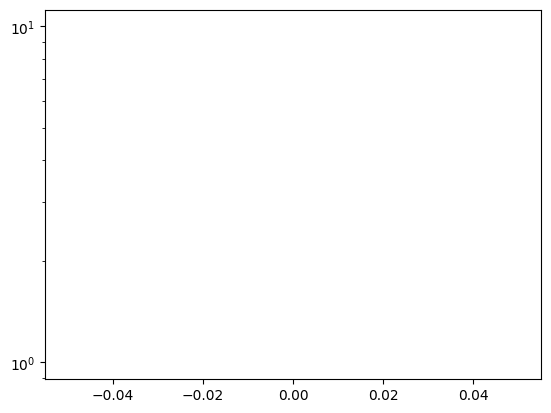

In [33]:
plt.plot(drag_f2cu2.index - 2, 0.05**2 * 0.20 / (4 * drag_f2cu2.Cd**2 * drag_f2cu2.mean_xVel**2))
plt.yscale('log')

In [34]:
drag_f2cu2.mean_xVel

2.00     NaN
2.01     NaN
2.02     NaN
2.03     NaN
2.04     NaN
        ... 
21.96    NaN
21.97    NaN
21.98    NaN
21.99    NaN
22.00    NaN
Name: mean_xVel, Length: 2001, dtype: object

## Below we smooth the velocity gradients and drag with a given kernel size

In [42]:
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size

cd_f1 = np.convolve(velGrad_F1cu2['cd'],kernel,mode = 'same')
cd_f2 = np.convolve(velGrad_F2cu2['cd'],kernel,mode = 'same')
#cd_f3 = np.convolve(velGrad_F3cu2['cd'], kernel, mode = 'same')
cd_f4 = np.convolve(velGrad_F4cu2['cd'],kernel,mode = 'same')
#cd_f5 = np.convolve(velGrad_F5cu2['cd'],kernel,mode = 'same')

cd_bf_f2 = np.convolve(velGrad_bf_F2cu2['cd'],kernel,mode = 'same')
cd_bf_f4 = np.convolve(velGrad_bf_F4cu2['cd'],kernel,mode = 'same')
#cd_bf_f5 = np.convolve(velGrad_bf_F5cu2['cd'],kernel,mode = 'same')


In [600]:
def drag2(body_data, u_f, sloped):
    
    nu = 1.95 * 10 **(-6)
    a = body_data
    b = a.iloc[np.where(a.x > 2)[0],:]
    c = b.iloc[np.where(b.y > 0.025)[0],:]
    if sloped == True:
        c = b
    c = c.sort_values('y')
    c.x = c.x.round(2)
    gb = c.groupby('x')

    xs = gb.groups.keys()
    df_linear = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd'])
    df_quartic = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd'])
    df_grad_upper = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd'])
    df_nearWall_diff = pd.DataFrame(index = xs, columns = ['slope', 'intercept', 'Cd'])
    i = 0
    
    #xs = np.linspace(2.01, 2.03, 3).round(2)
    u_fs = np.zeros((len(xs)))
    #cT = cmo.cm.matter_r(np.linspace(0,1,len(xs)+1))
    #fig, ax = plt.subplots(1,4, figsize = (20,5), dpi = 300)

    for x in xs:
        #ax[0].scatter(gb.get_group(x).avg_xVel, gb.get_group(x).y - 0.05, color = cT[i])

        ydata = np.array(gb.get_group(x).y)
        xVel_data = np.array(gb.get_group(x).avg_xVel)
        u_f = np.max(abs(xVel_data))
        u_fs[i] = u_f
        if sloped == True:
            ydata2 = ydata - np.max(ydata) + 0.05
            ydata = ydata2[np.where(ydata2 > 0.025)[0]]
            xVel_data = xVel_data[np.where(ydata2 > 0.025)[0]]

        new_y = np.linspace(0.025, ydata[-1], 50)
        new_xVel = griddata((np.array(ydata)), np.array(xVel_data), (new_y))

        params_quar, pcov = curve_fit(quartic, ydata, xVel_data, maxfev = 5000)
        dudy_quartic = quartic_deriv(ydata, *params_quar[0:-1]) 
        cond_quartic = np.where(dudy_quartic > 0)[0]


        dudy = np.gradient(new_xVel, new_y)
        cond_linear = np.where(dudy > 0)[0]
        
        cond_gradUpper = np.where(new_y > 0.04)[0]

        if len(cond_quartic) > 1:
            dudy_avg_quartic = np.nanmean(dudy_quartic[cond_quartic])

            df_quartic.iloc[i,0] = dudy_avg_quartic
            df_quartic.iloc[i,2]  = 2 * nu * dudy_avg_quartic  / u_f
            

        if len(cond_linear) > 1:
            params_linear, pcov = curve_fit(linear, new_y[cond_linear], new_xVel[cond_linear], maxfev = 5000)
            dudy_linear = params_linear[0]

            df_linear.iloc[i,0] = dudy_linear
            df_linear.iloc[i,2] = 2 * nu * dudy_linear  / u_f
            

        if len(cond_gradUpper) > 1:
            dudy_gradUpper = np.nanmean(np.gradient(new_xVel[cond_gradUpper], new_y[cond_gradUpper]))
            df_grad_upper.iloc[i,0] = dudy_gradUpper
            df_grad_upper.iloc[i,2] = 2 * nu * dudy_gradUpper  / u_f

            #ax[1].scatter(new_xVel[cond_gradUpper], new_y[cond_gradUpper], color = cT[i])


        dudy_nearWall = (new_xVel[-1] - new_xVel[-20]) / (new_y[-1] - new_y[-20])
        df_nearWall_diff.iloc[i,0] = dudy_nearWall
        df_nearWall_diff.iloc[i,2] = 2 * nu * dudy_nearWall  / u_f

        
        # ax[2].scatter(new_xVel, new_y, color = cT[i])
        # ax[2].scatter(new_xVel[-1], new_y[-1], color = 'red')
        # ax[2].scatter(new_xVel[-7], new_y[-7], color = 'red')
                
        # rmse[0] = np.sqrt(np.mean((xVel_data - linear(ydata, *params_l)) ** 2))
        # rmse[1] = np.sqrt(np.mean((xVel_data - quadratic(ydata, *params_quad)) ** 2))
        # rmse[2] = np.sqrt(np.mean((xVel_data - cubic(ydata, *params_c)) ** 2))
        # rmse[3] = np.sqrt(np.mean((xVel_data - quartic(ydata, *params_quar)) ** 2))
        # rmse[4] = np.sqrt(np.mean((xVel_data - exponential(ydata, *params_e)) ** 2))

        # idx = np.argmin(rmse)

        # if idx == 0:
        #     #print('linear')
        #     rmse_all[i] = 0#rmse[0]
        # elif idx == 1:
        #     #print('quadratic')
        #     rmse_all[i] = 1#rmse[1]
        # elif idx == 2:
        #     #print('cubic')
        #     rmse_all[i] = 2#rmse[2]
        # elif idx == 3:
        #     #print('quartic')
        #     rmse_all[i] = 3#rmse[3]
        # else:
        #     #print('exponential')
        #     rmse_all[i] = 4#rmse[4]

        #ax[1].plot(quartic_deriv(ydata, a, b, c, d), ydata, color = cT[i])

        #df.iloc[i,0] = np.mean(abs(cubic_deriv(xdata, a, b, c,d)))
        #df.iloc[i,1] = popt[1]

        i = i + 1

    # ax[0].set_xlabel('x-velocity [m/s]')
    # ax[1].set_xlabel('x-velocity gradient')
    # ax[2].set_xlabel('x-velocity where gradient > 0')
    # ax[3].set_xlabel('linear fit to x-velocity profile')
    # ax[0].set_ylabel('Distance from the Ice')
    # ax[2].legend(np.round(xs - 2, 2) * 100, loc = 4)
    # plt.savefig('dudy_linearFit.png')
    return df_linear, df_quartic, df_grad_upper, df_nearWall_diff, u_fs

In [601]:
linear_F1cu1, quartic_F1cu1, grad_upper_F1cu1, nearWall_diff_F1cu1, ufs_F1cu1 = drag2(F1cu1_body, 0.05, False)
linear_F1cu2, quartic_F1cu2, grad_upper_F1cu2, nearWall_diff_F1cu2, ufs_F1cu2 = drag2(F1cu2_body, 0.05, False)
linear_F1cu3, quartic_F1cu3, grad_upper_F1cu3, nearWall_diff_F1cu3, ufs_F1cu3 = drag2(F1cu3_body, 0.05, False)

linear_F2cu1, quartic_F2cu1, grad_upper_F2cu1, nearWall_diff_F2cu1, ufs_F2cu1 = drag2(F2cu1_body, 0.005, False)
linear_F2cu2, quartic_F2cu2, grad_upper_F2cu2, nearWall_diff_F2cu2, ufs_F2cu2 = drag2(F2cu2_body, 0.005, False)
linear_F2cu3, quartic_F2cu3, grad_upper_F2cu3, nearWall_diff_F2cu3, ufs_F2cu3 = drag2(F2cu3_body, 0.005, False)

linear_F3cu2, quartic_F3cu2, grad_upper_F3cu2, nearWall_diff_F3cu2, ufs_F3cu2 = drag2(F3cu2_body, 0.0005, False)

linear_F4cu2, quartic_F4cu2, grad_upper_F4cu2, nearWall_diff_F4cu2, ufs_F4cu2 = drag2(F4cu2_body, 0.005, True)




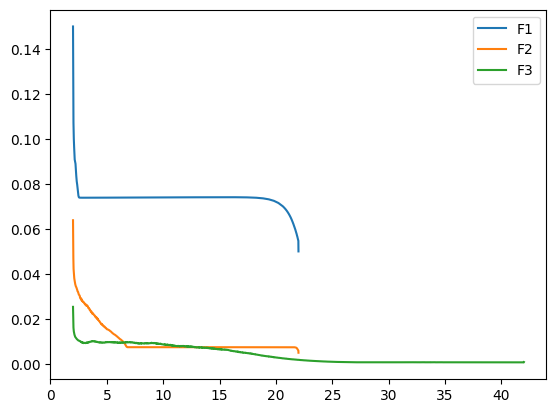

In [606]:
plt.plot(linear_F1cu2.index, ufs_F1cu2, label = 'F1')
plt.plot(linear_F2cu2.index, ufs_F2cu2, label = 'F2')
plt.plot(linear_F3cu2.index, ufs_F3cu2, label = 'F3')
plt.legend()

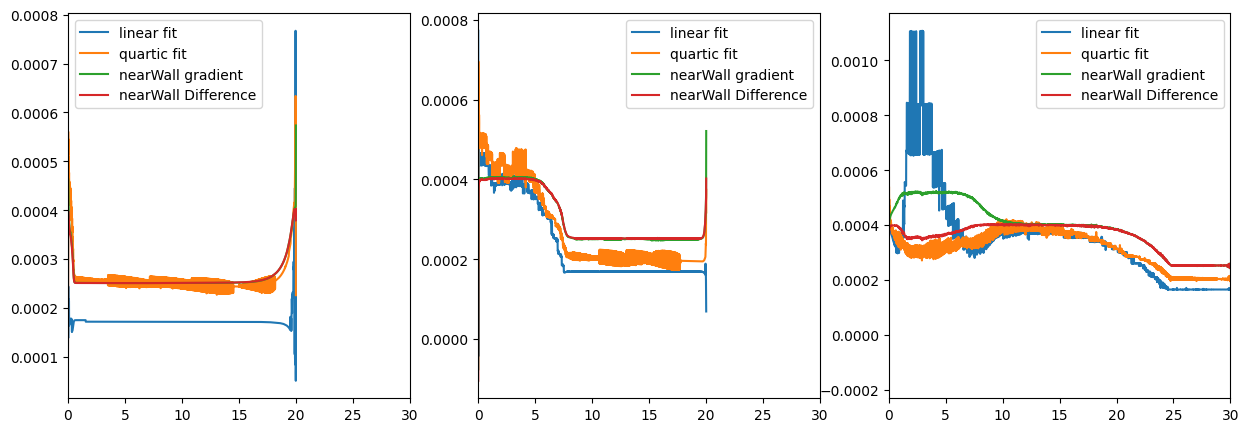

In [599]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(linear_F1cu2.index - 2, linear_F1cu2.Cd, label = 'linear fit')
ax[0].plot(quartic_F1cu2.index - 2, quartic_F1cu2.Cd, label = 'quartic fit')
ax[0].plot(grad_upper_F1cu2.index - 2, grad_upper_F1cu2.Cd, label = 'nearWall gradient')
ax[0].plot(nearWall_diff_F1cu2.index -2, nearWall_diff_F1cu2.Cd, label = 'nearWall Difference')
ax[0].legend()
ax[0].set_xlim(0,30);

ax[1].plot(linear_F4cu2.index - 2, linear_F4cu2.Cd, label = 'linear fit')
ax[1].plot(quartic_F4cu2.index - 2, quartic_F4cu2.Cd, label = 'quartic fit')
ax[1].plot(grad_upper_F4cu2.index - 2, grad_upper_F4cu2.Cd, label = 'nearWall gradient')
ax[1].plot(nearWall_diff_F4cu2.index -2, nearWall_diff_F4cu2.Cd, label = 'nearWall Difference')
ax[1].legend()
ax[1].set_xlim(0,30);

ax[2].plot(linear_F3cu2.index - 2, linear_F3cu2.Cd, label = 'linear fit')
ax[2].plot(quartic_F3cu2.index - 2, quartic_F3cu2.Cd, label = 'quartic fit')
ax[2].plot(grad_upper_F3cu2.index - 2, grad_upper_F3cu2.Cd, label = 'nearWall gradient')
ax[2].plot(nearWall_diff_F3cu2.index -2, nearWall_diff_F3cu2.Cd, label = 'nearWall Difference')
ax[2].legend()
ax[2].set_xlim(0,30); #plt.yscale('log')
#plt.ylim(0,0.001)

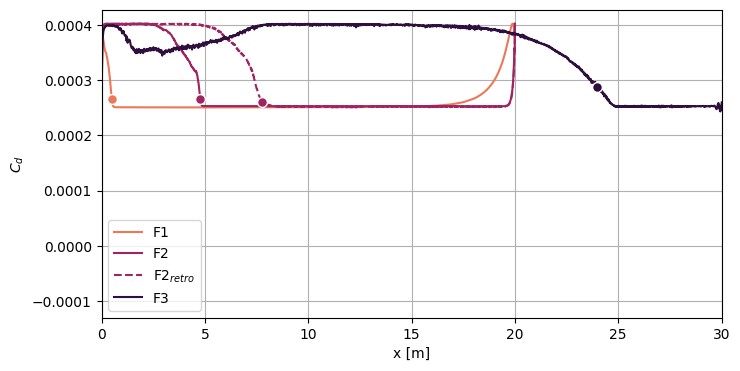

In [598]:
fig, ax = plt.subplots(1, figsize = (8,4))

cT = cmo.cm.matter_r(np.linspace(0,1,4))

ax.plot(nearWall_diff_F1cu2.index - 2, nearWall_diff_F1cu2.Cd, color = cT[2], label = 'F1')
intru = np.argmin(abs(np.array(nearWall_diff_F1cu2.index - 2) - f1cu2_intru))
ax.scatter(nearWall_diff_F1cu2.index[intru] - 2, nearWall_diff_F1cu2.Cd.iloc[intru], color = cT[2],
           s = 50,edgecolor='white',linewidth = 1, zorder = 2)

ax.plot(nearWall_diff_F2cu2.index - 2, nearWall_diff_F2cu2.Cd, color = cT[1], label = 'F2')
intru = np.argmin(abs(np.array(nearWall_diff_F2cu2.index - 2) - f2cu2_intru))
ax.scatter(nearWall_diff_F2cu2.index[intru] - 2, nearWall_diff_F2cu2.Cd.iloc[intru], color = cT[1],
           s = 50,edgecolor='white',linewidth = 1, zorder = 2)

## Need to Refine
ax.plot(nearWall_diff_F4cu2.index - 2, nearWall_diff_F4cu2.Cd, color = cT[1], linestyle = '--', label = 'F2$_{retro}$')
intru = np.argmin(abs(np.array(nearWall_diff_F4cu2.index - 2) - f4cu2_theta1_intru))
ax.scatter(nearWall_diff_F4cu2.index[intru] - 2, nearWall_diff_F4cu2.Cd.iloc[intru], color = cT[1],
           s = 50,edgecolor='white',linewidth = 1, zorder = 2)

ax.plot(nearWall_diff_F3cu2.index - 2, nearWall_diff_F3cu2.Cd, color = cT[0], label = 'F3')
intru = np.argmin(abs(np.array(nearWall_diff_F3cu2.index - 2) - f3cu2_intru))
ax.scatter(nearWall_diff_F3cu2.index[intru] - 2, nearWall_diff_F3cu2.Cd.iloc[intru], color = cT[0],
           s = 50,edgecolor='white',linewidth = 1, zorder = 2)

ax.legend()
ax.set_xlim(0,30)
ax.set_xlabel('x [m]')
ax.set_ylabel('$C_d$')
#ax.set_yscale('log')
ax.grid()
#ax.set_ylim(0,0.01)
#ax.set_yscale('log')
plt.savefig('drag.png', dpi = 500)